# Introdução

SVM é uma técnica de aprendizado supervisionado utilizada principalmente em problemas de classificação binária. 

A ideia do SVM é encontrar um limite de decisão linear, também chamado de hiperplano, que melhor separa nossos dados. Na figura abaixo podemos ver que este melhor hiperplano é aquele que representa a maior separação ou a maior margem entre as 2 classes. 



![roc.svg](images/svm.png)
<center>Ilustração do modelo SVM (Fonte: https://en.wikipedia.org/wiki/Support-vector_machine)</center>

A classificação da SVM ocorrerá da seguinte maneira:

- w . xi - b >= 1 se yi = 1

- w . xi - b<= -1 se yi = -1

Colocando em uma equação temos:

- yi . (w . xi - b)>= 1

Além disso, deseja-se maximizar a separação, dada por (2/||w||), o que é equivalente a minimizar ||w||. 

A partir daí o processo se torna um problema de otimização  para encontrar a melhor solução dos pesos w e do termo b (bias) que obedeçam as condições acima.

# Gerando base de dados

Abaixo está um algoritmo em python para geração dos dados da espiral solicitada no exercício.

In [22]:
# Imports:
from numpy import pi
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC as svm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import plot_confusion_matrix

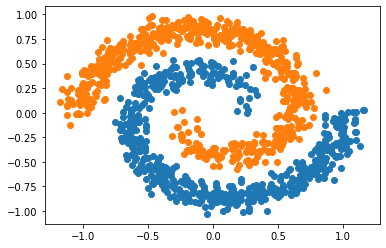

In [23]:
# Generating spiral data:
# (Code from: https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5)
N = 600
theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

r_a = 2*theta + pi
data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
x_a = (data_a + np.random.randn(N,2))/15

r_b = -2*theta - pi
data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
x_b = (data_b + np.random.randn(N,2))/15

res_a = np.append(x_a, np.zeros((N,1)), axis=1)
res_b = np.append(x_b, np.ones((N,1)), axis=1)

res = np.append(res_a, res_b, axis=0)
np.random.shuffle(res)

np.savetxt("spiral_data.csv", res, delimiter=",", header="x,y,label", comments="", fmt='%.5f')

plt.scatter(x_a[:,0],x_a[:,1])
plt.scatter(x_b[:,0],x_b[:,1])
plt.show()

# Separando os dados em treinamento e teste

Abaixo foi realizada uma visualização da estrutura dos dados e feita a separação aleatória deles em dados de treinamento (75%) e dados de teste (25%)

In [24]:
# Loading dataset:
df = pd.read_csv("spiral_data.csv")
df.head()


,x,y,label
0,-0.19230,0.46234,0.0
1,0.18587,0.92255,1.0
2,0.09719,0.78060,1.0
3,-0.94377,0.43297,1.0
4,0.58239,-0.58020,0.0


In [25]:
X = df[["x","y"]]
y = df["label"]

# Labels -1 and 1:
y = np.where(y <= 0, -1, 1)

# Separate data between training and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11111)

# Treinamento SVM

Para o treinamento inicial decidiu-se utilizar o parâmetro C igual a 10 (posteriormente será testado mais valores e observado qual obteve melhores resultados). Além disso o tipo de kernel escolhido foi o rbf. 

Como descrito em [1], ao treinar um SVM com o kernel Radial Basis Function (RBF), dois parâmetros devem ser considerados: C e gama. O parâmetro C, comum a todos os kernels SVM, compensa a classificação incorreta dos exemplos de treinamento pela simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto visa classificar todos os exemplos de treinamento corretamente. Já o parâmetro gamma define quanta influência um único exemplo de treinamento tem. Quanto maior for o gamma, mais próximos os outros exemplos devem estar para serem afetados. Esse parâmetro foi mantido em seu valor padrão, dado por: 1/(n_features*X.var()).

In [26]:
clf = svm(kernel="rbf", C=10)
clf.fit(X_train, y_train)

SVC(C=10)

# Plotando os dados no espaço de entrada resaltando os vetores de suporte

Text(0.5, 1.0, 'Dados de entrada com vetores suporte destacaos em preto.')

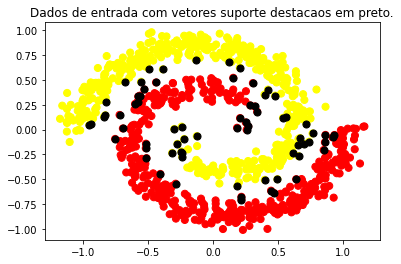

In [27]:
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, s=50, cmap='autumn')
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=50, lw=1, facecolors='black');
plt.title("Dados de entrada com vetores suporte destacaos em preto.")

# Plotando os dados no espaço de entrada com o hiperplano de separação

Text(0.5, 1.0, 'Dados de entrada com hiperplano de separação.')

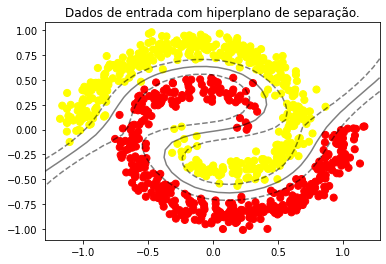

In [28]:
# Plot data into input space highlighting support vectors 
# (Code from: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)
def plot_svc_decision_function(model, ax=None, plot_support=True, vectors_color="none"):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=30, linewidth=0.5, facecolors=vectors_color);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, s=50, cmap='autumn')
plot_svc_decision_function(model = clf);
plt.title("Dados de entrada com hiperplano de separação.")

# Plotando superfície de separação

Text(0.5, 0.92, 'Superfície de separação.')

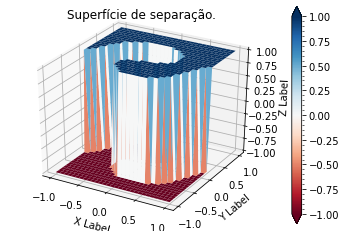

In [29]:
def plot_svc_surface(model, plot_support=True, vectors_color="none"):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # create grid to evaluate model
    x = np.linspace(-1, 1, 30)
    y = np.linspace(-1, 1, 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    Z = clf.predict(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    figure= ax.plot_surface(X, Y, Z,rstride=1, cstride=1, cmap='RdBu',edgecolor='none')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    cbar = fig.colorbar(figure, ax=ax, extend='both')
    cbar.minorticks_on()


plot_svc_surface(model = clf);
plt.title("Superfície de separação.")

# Aplicação do modelo aos dados de teste e cálculo da acurácia

In [31]:
for C in [1, 2, 3, 4, 5, 6, 7, 8,9,10]:
    clf = svm(kernel="rbf", C=C)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # Print model performance
    print('for C = ' + str(C) + ', accuracy is {:.3f}'.format(accuracy_score(y_test,y_pred)))



for C = 1, accuracy is 0.990
for C = 2, accuracy is 0.993
for C = 3, accuracy is 1.000
for C = 4, accuracy is 0.997
for C = 5, accuracy is 1.000
for C = 6, accuracy is 1.000
for C = 7, accuracy is 1.000
for C = 8, accuracy is 1.000
for C = 9, accuracy is 1.000
for C = 10, accuracy is 1.000


Como pode-se ver acima para todos os valores de C obteve-se bons resultados, sendo que os valores de C iguais a 3 e de 5 até 10, obteve-se acurácia máxima para o teste realizado. Apesar de nesse exemplo ter-se encontrado bons resultados para todos os valores de C testados, destaca-se que a escolha adequada de C e gama é crítica para o desempenho do SVM. A documentação do scikit-learn aconselha inclusive usar GridSearchCV com C e gama espaçados exponencialmente para escolher bons valores. 

Abaixo foi ainda gerada a matrix de confusão do resultado da predição para C=10.

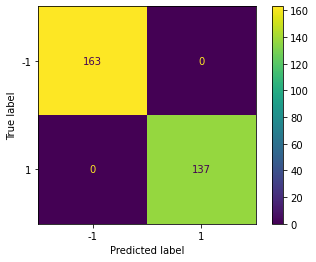

In [32]:
plot_confusion_matrix(clf, X_test, y_test)